# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

Task: LIME provides Local Interpretable Model-agnostic Explanations. The main intuition behind LIME is that it learns an interpretable model locally around the prediction. Visualize, for the 10 given ImageNet data points which parts them are responsible for the main prediction using LIME.
Please, follow the tutorial on LIME from:
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20 Pytorch.ipynb
Deliverable 2: For the 10 given ImageNet images, obtain and plot the annotations by LIME and analyze your results in a short report.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

from lime import lime_image


from skimage.segmentation import mark_boundaries

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load functions we will use

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
#We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)



#We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

#For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

# Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


Load our test image and see how it looks.

In [3]:
### Load file names

directory = '/Users/nursulusagimbayeva/Downloads/TrustworthyML-24/neural_networks_explainability/Assignment_4/LIME/data'
file_names = os.listdir(directory)

In [5]:
# Load the pretrained model for Resnet50 available in Pytorch.
model = models.inception_v3(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load label texts for ImageNet predictions so we know what model is predicting

In [7]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}  

In [12]:
file_names = [el for el in file_names if el!= '.DS_Store']

In [18]:
file_names

['n01677366_common_iguana 11.28.50.JPEG',
 'n07747607_orange 11.28.50.JPEG',
 'n04037443_racer 11.28.50.JPEG',
 'imagenet_class_index.json',
 'n01616318_vulture 11.28.50.JPEG',
 'n01491361_tiger_shark 11.28.50.JPEG',
 'n02007558_flamingo 11.28.50.JPEG',
 'n01608432_kite 11.28.50.JPEG',
 'n02018207_American_coot 11.28.50.JPEG',
 'n01443537_goldfish.JPEG',
 'n02098286_West_Highland_white_terrier 14.29.46.JPEG']

file: n02098286_West_Highland_white_terrier 14.29.46.JPEG
Predicted label: West_Highland_white_terrier


100%|██████████| 1000/1000 [00:21<00:00, 45.65it/s]


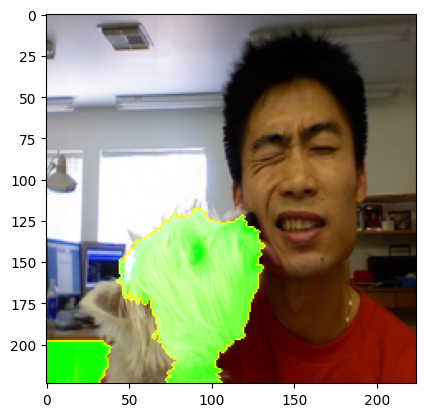

In [37]:
file = file_names[10]
print("file:", file)
img = get_image(f'./data/{file}')
#transform to tensors
img_t = get_input_tensors(img)

#get prediction for orig. image
model.eval()
logits = model(img_t)

# print most likely prediction: logits through softmax
probs = F.softmax(logits, dim=1)
probs1 = probs.topk(1)
tuple((p,c, idx2label[c]) for p, c in zip(probs1[0][0].detach().numpy(), probs1[1][0].detach().numpy()))


pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

test_pred = batch_predict([pill_transf(img)])
pred_label = test_pred.squeeze().argmax()
print("Predicted label:", idx2label[pred_label])

#create explanation for this prediciton.


explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                        batch_predict, # classification function
                                        top_labels=5, 
                                        hide_color=0, 
                                        num_samples=1000) # number of images that will be sent to classification function


# add mask to see the areas contributing the most to the prediction
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
# plt.savefig('results/white_terrier_against.jpg', format='jpg', bbox_inches='tight')
plt.imshow(img_boundry1)
    

In [28]:
probs1 = probs.topk(5)

In [29]:
probs1

torch.return_types.topk(
values=tensor([[0.1497, 0.1259, 0.0979, 0.0666, 0.0655]], grad_fn=<TopkBackward0>),
indices=tensor([[376, 986, 957,  88, 365]]))

In [34]:
idx2label[365]

'orangutan'

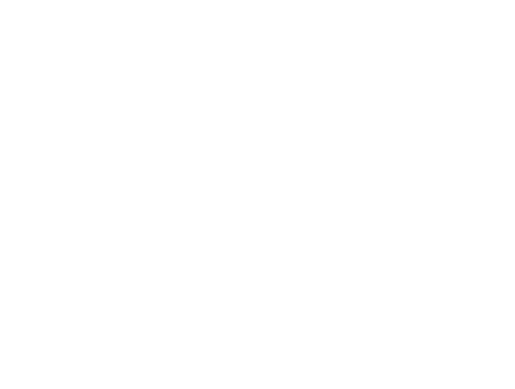

In [21]:
plt.axis('off')
plt.savefig('results/white_terrier_against.png')

In [14]:
# Save the figure
output_path = 'output_image_with_mask.png'
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

# Optionally, show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

Get the predicition for our image.

In [10]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Let's test our function for the sample image.

In [15]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

203

Import lime and create explanation for this prediciton.

In [17]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

100%|██████████| 1000/1000 [00:22<00:00, 45.40it/s]


Let's use mask on image and see the areas that are encouraging the top prediction.

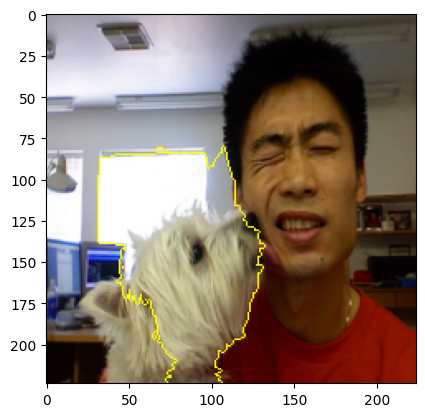

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.savefig('results/white_terrier_against.jpg', format='jpg', bbox_inches='tight')
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

In [22]:
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# img_boundry2 = mark_boundaries(temp/255.0, mask)
# plt.imshow(img_boundry2)